# CH1. EDA

###### EDA에서 뺴놓을 수 없는것! 예측값들 간의, 혹은예측값과 목푯값과의 상관관계를 조사해보는 일!

(p.50~)

x가 큰 값을 가지면 y도 큰 값을 갖고, x가 작은 값을 가지면 y도 작은 값을 갖는 경우: 변수 x와 y는 서로 양의 상관관계를 갖는다.

x가 큰 값을 가지면 y는 작은 값을 갖고, x가 작은 값을 가지면 y가 큰 값을 갖는 경우: 변수 x와 y는 서로 음의 상관관계를 갖는다.

보통 상관계수 하면 피어슨의 상관계수이지만, 그외 Spearman's rho, Kendall's tau 등 다른 형태의 상관계수 들도 있다.

이들은 데이터의 순위를 기초로 하는 상관계수로, 값 자체 보다 값의 순위를 이용하기 때문에 특잇값에 좀 더 강건하며 비선형 관계도 다룰 수 있다고 한다.

하지만 일반적으로 피어슨 상관계수를 이용하며, 이것의 로버스트한 다른 버전들을 쓴다.

순위 기반 추정법은 보통 데이터의 크기가 작고, 특별한 가설 검정이 필요할 때 주로 사용된다고 한다.

##### 주요 용어 정리

> 상관계수(correlation coefficient): 수치적 변수들 간에 어떤 관계가 있는지를 나타내기 위해 사용되는 측정량 (-1 에서 +1 사이 값을 갖는다.)

> 상관행렬(correlation matrix): 행과 열이 변수들을 의미하는 표. 각 셀은 그 행과 열에 해당하는 변수들간의 상관관계를 의미한다.

> 산점도(scatterplot): x축과 y축이 서로 다른 두 개의 변수를 나타내는 도표



---

##### 요약

> 상관계수는 두 변수 사이에 서로 어떤 관계가 있는지를 측정한다.

> 변수1이 높아질 때 변수2도 높아지고, 변수1이 낮아질 때 변수2도 낮아지면 이들은 양의 상관관계가 있다고 하며, 서로의 변화가 반대일 경우 음의 상관관계가 있다고 한다.

> 상관계수는 표준화된 측정 지표라고 할 수 있다. 항상 그 값은 -1(완전 음의 상관관계) 에서 +1(완전 양의 상관관계) 사이에 존재한다.

> 상관계수가 0이라는 뜻은 아무런 상관성이 없음을 의미한다. 

> 하지만 데이터를 랜덤하게 재배치하면 우연히 상관계수가 양수 혹은 음수가 될 수도 있다는 점을 알고 있어야 한다.

In [1]:
# 라이브러리 불러오기

%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

## 데이터 import

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

## 상관계수

상관계수는 주로 피어슨 상관계수를 구하기 때문에 피어슨 상관계수라고 한다.

*스피어먼 상관 계수는 순위가 매겨진 변수 간의 피어슨 상관 계수 로 정의된다. 

따라서 통계적 계산에서 순서척도가 적용되는 상관분석에서는 스피어먼 상관 계수가 사용되며 간격척도가 적용되는 변수들 간의 분석에서는 피어슨 상관 계수가 사용된다. -wiki 스피어먼상관계수
(https://ko.wikipedia.org/wiki/%EC%8A%A4%ED%94%BC%EC%96%B4%EB%A8%BC_%EC%83%81%EA%B4%80_%EA%B3%84%EC%88%98)*

### 통신사 주식의 일간 수익 사이의 상관관계 구하기

In [4]:
# data 

sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [5]:
# sp500의 sector까지 적혀있는 주식 목록

sp500_sym

,sector,sector_label,sub_sector,symbol
0,information_technology,Technology,data_processing_&_outsourced_services,ADS
1,information_technology,Technology,systems_software,CA
2,information_technology,Technology,systems_software,MSFT
3,information_technology,Technology,systems_software,RHT
4,information_technology,Technology,it_consulting_&_services,CTSH
...,...,...,...,...
512,health_care,Health Care,biotechnology,CELG
513,health_care,Health Care,biotechnology,GILD
514,health_care,Health Care,biotechnology,REGN
515,health_care,Health Care,biotechnology,VRTX


In [7]:
# sp500 의 주식 가격

sp500_px

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,...,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.000000,0.060124,-0.022100,0.000000,0.000000,0.018897,0.007368,0.092165,0.259140,-0.007105,...,0.000000,0.000000,0.347160,0.000000,0.041670,0.000000,0.015564,1.750000,0.125000,0.000000
1993-02-01,0.000000,-0.180389,0.027621,0.000000,0.000000,0.018889,0.018425,0.115207,-0.100775,0.063893,...,0.000000,0.000000,-0.231440,0.000000,0.000000,-0.010410,0.007782,1.250000,0.125000,0.000000
1993-02-02,0.000000,-0.120257,0.035900,0.000000,0.000000,-0.075573,0.029482,-0.023041,0.028796,-0.014192,...,0.000000,0.000000,-0.115720,0.000000,0.000000,0.000000,-0.007792,-0.250000,0.000000,0.000000
1993-02-03,0.000000,0.060124,-0.024857,0.000000,0.000000,-0.151128,0.003689,-0.253454,-0.043190,-0.007105,...,0.000000,0.000000,-0.086790,0.000000,0.041670,-0.041670,-0.038919,-0.500000,0.062500,0.000000
1993-02-04,0.000000,-0.360770,-0.060757,0.000000,0.000000,0.113350,-0.022114,0.069862,0.000000,-0.007096,...,0.000000,0.000000,0.144650,0.000000,-0.041660,-0.031260,-0.046711,0.000000,0.062500,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-25,0.019989,-0.529999,-0.379997,0.080002,0.350003,-0.580002,-0.457999,-1.720001,-0.009936,0.039997,...,-2.500000,1.889999,-2.060012,0.150002,-1.630004,-0.990005,-2.250000,1.270019,-1.919998,-0.080002
2015-06-26,-1.299988,-0.330000,-0.390004,-1.820000,0.190003,0.330002,-0.328565,-0.769989,0.020000,0.000000,...,-0.070007,-2.380005,-1.390000,0.550004,-3.509979,-1.080002,-0.800003,-1.900024,-3.629997,0.440002
2015-06-29,-10.299988,-0.410000,-0.670002,-1.250000,-1.919998,-0.510002,-0.139999,-0.949997,-0.100000,-0.040001,...,-2.250000,-5.490005,-5.029999,0.090000,-8.290009,-1.209999,-2.419998,-9.620026,-3.770004,-2.479996
2015-06-30,-2.109986,-0.049999,-0.559997,-0.099999,-0.689999,-0.610001,0.239999,-1.330001,-0.200000,0.020001,...,-0.299988,0.270004,0.279999,-1.710001,0.390014,0.439995,-0.209999,-2.070007,-0.849999,-1.360001


In [13]:
#  통신사 주식 데려오기

sp500_sym[sp500_sym['sector_label']=='Telecom']

# 정답은 sp500_sym[sp500_sym['sector_label']== 'telecommunications_services'] 이기는 하다.

332       T
333     CTL
334     FTR
335      VZ
336    LVLT
Name: symbol, dtype: object

### 상관 행렬 만들기

In [22]:
# 통신사 주식 데려와 상관관계를 나타내는 상관행렬 만들기

# 회사 symbol 선언
TelecomSymbols = sp500_sym[sp500_sym['sector_label']=='Telecom']['symbol']

# telecom 주식들의 가격 가져오기, 해당 조건의 행과 열에 위치한 아이들만.
telecom_prices = sp500_px.loc[sp500_px.index >= '2012-07-01', TelecomSymbols]

telecom_prices

,T,CTL,FTR,VZ,LVLT
2012-07-02,0.422496,0.140847,0.070879,0.554180,-0.519998
2012-07-03,-0.177448,0.066280,0.070879,-0.025976,-0.049999
2012-07-05,-0.160548,-0.132563,0.055128,-0.051956,-0.180000
2012-07-06,0.342205,0.132563,0.007875,0.140106,-0.359999
2012-07-09,0.136883,0.124279,-0.023626,0.253943,0.180000
...,...,...,...,...,...
2015-06-25,0.049342,-1.600000,-0.040000,-0.187790,-0.330002
2015-06-26,-0.256586,0.039999,-0.070000,0.029650,-0.739998
2015-06-29,-0.098685,-0.559999,-0.060000,-0.504063,-1.360000
2015-06-30,-0.503298,-0.420000,-0.070000,-0.523829,0.199997


In [23]:
telecom_prices.corr()

,T,CTL,FTR,VZ,LVLT
T,1.000000,0.474683,0.327767,0.677612,0.278626
CTL,0.474683,1.000000,0.419757,0.416604,0.286665
FTR,0.327767,0.419757,1.000000,0.287386,0.260068
VZ,0.677612,0.416604,0.287386,1.000000,0.242199
LVLT,0.278626,0.286665,0.260068,0.242199,1.000000


이렇게 여러 변수들 사이의 관계를 시각화 하는 데 사용할 수 있다. 

### seaborn으로 상관관계 히트맵 그리기

<AxesSubplot:>

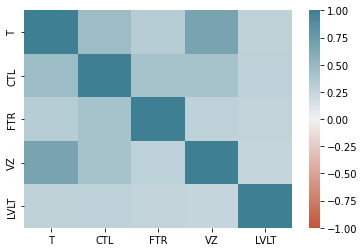

In [26]:
sns.heatmap(telecom_prices.corr(), vmin = -1, vmax = 1, 
           cmap = sns.diverging_palette(20, 220, as_cmap = True))

#### etf 들의 일간 수익 사이의 상관관계

를 구해볼 수도 있다.

In [27]:
etfs = sp500_px.loc[sp500_px.index > '2012-01-01',
                   sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]

<AxesSubplot:>

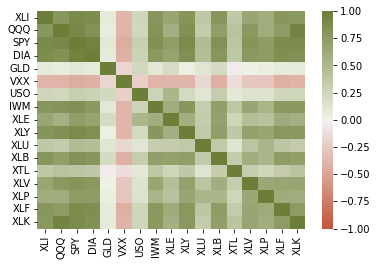

In [33]:
sns.heatmap(etfs.corr(), vmin=-1, vmax=1,
           cmap = sns.diverging_palette(20, 100, as_cmap = True))

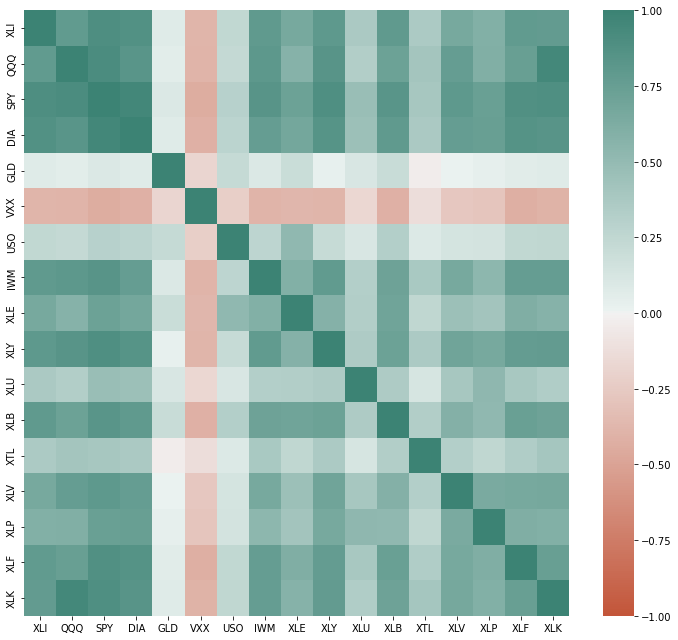

In [36]:
# 크기 조절하기

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 170, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

---

## 산점도

두 변수 사이의 관계를 시각화하는 가장 기본적인 방법이다.

x, y 축에 각각의 변수를 위치시키고, 그래프의 각 점은 하나의 레코드를 의미한다.

특정 통신산업 회사 간의 일간 수익의 상관관계를 그림으로 타나내보자.

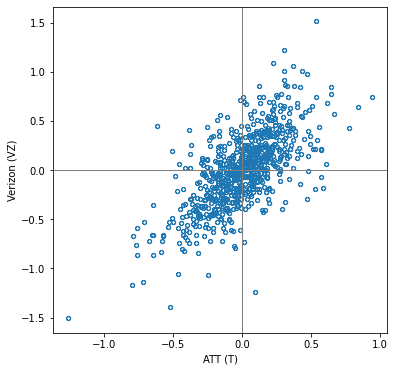

In [41]:
# 원형 동그라미로 AT&T와 버라이즌의 일간 수익 상관관계 그리기
scat_plot = telecom_prices.plot.scatter(x = 'T', y = 'VZ', figsize = (6, 6), marker = '$\u25EF$')

# 그래프 축 이름
scat_plot.set_xlabel('ATT (T)')
scat_plot.set_ylabel('Verizon (VZ)')

# 그래프 x = 0, y = 0 선 그리기
scat_plot.axhline(0, color = 'grey', lw = 1)
scat_plot.axvline(0, color = 'grey', lw = 1)

위를 해석한다면 두 회사의 수익 모두 0 주변에 몰려있긴 하지만 강한 양의 상관성을 띠고 있다. 

제 1 사분면, 3 사분면에 데이터가 더 많은 것을 보면 이는 거의 매일, 두 주식은 함께 오르거나 함께 떨어졌다는 의미이다. 

제 2 사분면, 4 사분면에 데이터는 서로 반대로 오르거나 떨어지는 경우로, 상대적으로 적다.